# 1.0 create 2d hexagonal density

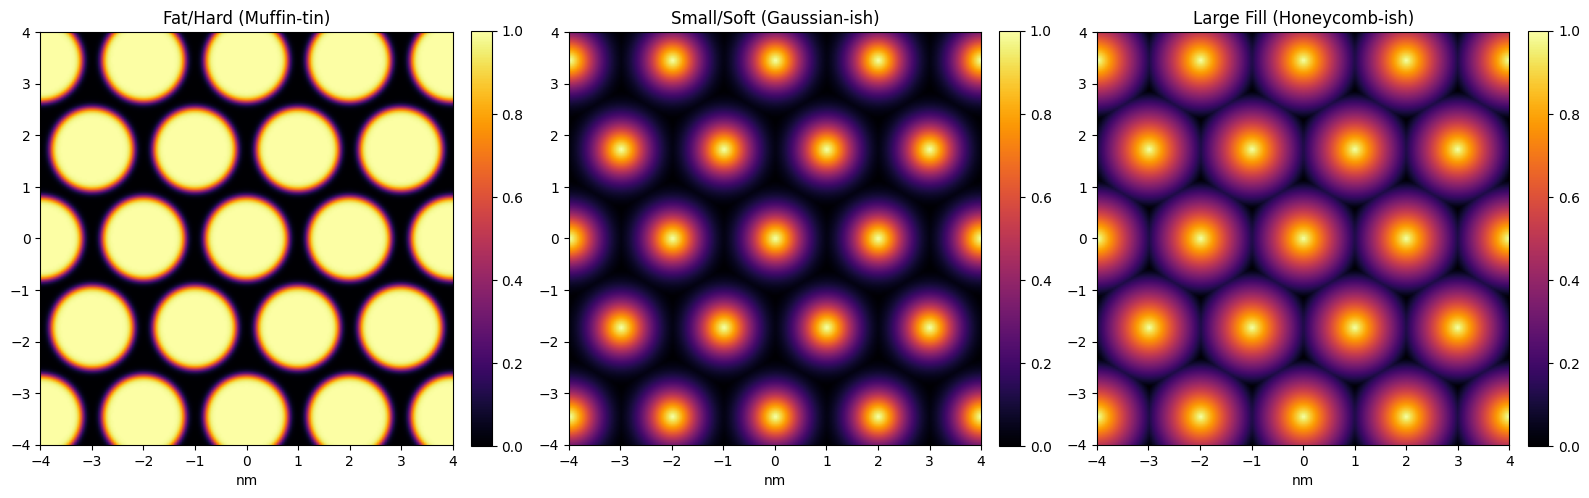

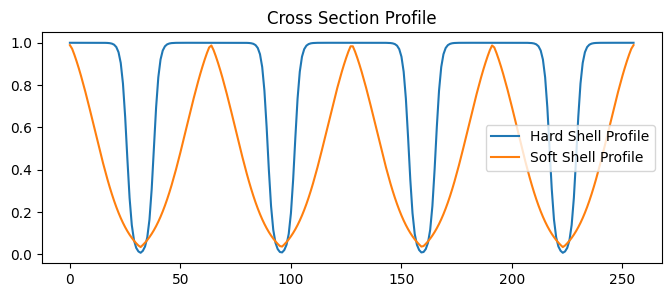

In [43]:
import numpy as np
import matplotlib.pyplot as plt

def generate_distance_field_lattice(
    shape: tuple = (256, 256), 
    fov: float = 10.0, 
    lattice_a: float = 1.0, 
    step_center: float = 0.5, 
    step_sharpness: float = 20.0
) -> tuple[np.ndarray, list]:
    """
    Generates a hexagonal lattice density map using a Distance Field algorithm.
    
    Algorithm:
    1. Calculate phi(x,y): Euclidean distance to the nearest lattice point.
       (phi is non-smooth at Voronoi boundaries).
    2. Normalize phi: 0 at lattice point, 1 at triangular void center.
    3. Apply Sigmoid Shaping: s(phi) -> Maps distance to density [0, 1].

    Parameters:
    -----------
    shape : tuple
        Output resolution (height, width).
    fov : float
        Field of View in real space (e.g., 10.0 nm).
    lattice_a : float
        Lattice constant (distance between atoms).
    step_center : float (0.0 ~ 1.0)
        The radius of the 'atom' or 'domain'.
        - Defines the threshold distance where density drops to 0.5.
        - Larger value = Fatter atoms / Smaller voids.
    step_sharpness : float
        The hardness of the domain edge.
        - High value (>50): Sharp, binary-like edges (Hard spheres).
        - Low value (<10): Soft, fuzzy edges (Gaussian-like).

    Returns:
    --------
    Z_final : np.ndarray
        Density map normalized to [0, 1].
    extent : list
        [min_x, max_x, min_y, max_y] for plotting.
    """
    ny, nx = shape
    
    # 1. Grid Generation (Real Space)
    aspect_ratio = ny / nx
    x = np.linspace(-fov/2, fov/2, nx)
    y = np.linspace(-fov*aspect_ratio/2, fov*aspect_ratio/2, ny)
    X, Y = np.meshgrid(x, y)
    
    # 2. Coordinate Transformation to Hexagonal Basis (u, v)
    # Basis vectors: a1 = (a, 0), a2 = (a/2, a*sqrt(3)/2)
    # We want to find u, v such that (x,y) = u*a1 + v*a2
    # Derived inverse:
    # u = x/a - y/(a*sqrt(3))
    # v = 2y / (a*sqrt(3))
    
    sqrt3 = np.sqrt(3)
    u_raw = X / lattice_a - Y / (lattice_a * sqrt3)
    v_raw = 2 * Y / (lattice_a * sqrt3)
    
    # 3. Find Nearest Lattice Point (Vectorized)
    # The nearest integer point (i,j) in oblique coordinates is one of the 
    # 4 corners of the parallelogram enclosing (u, v).
    
    u_floor = np.floor(u_raw)
    v_floor = np.floor(v_raw)
    
    # Candidate integer coordinates (4 neighbors)
    # We stack them to shape (4, ny, nx) to compute min distance efficiently
    candidates_u = np.stack([u_floor, u_floor+1, u_floor, u_floor+1])
    candidates_v = np.stack([v_floor, v_floor, v_floor+1, v_floor+1])
    
    # Convert candidates back to Real Space (Cartesian)
    # x = (u + v/2) * a
    # y = (sqrt(3)/2 * v) * a
    cand_x = (candidates_u + candidates_v / 2.0) * lattice_a
    cand_y = (candidates_v * sqrt3 / 2.0) * lattice_a
    
    # Calculate Squared Euclidean Distance to all 4 candidates
    dist_sq = (X - cand_x)**2 + (Y - cand_y)**2
    
    # Find the minimum distance (Distance Field phi_raw)
    min_dist_sq = np.min(dist_sq, axis=0)
    phi_raw = np.sqrt(min_dist_sq)
    
    # 4. Normalize Distance Field (phi)
    # Max distance in triangular lattice is at the centroid of the void.
    # Radius = a / sqrt(3)
    max_dist_theoretical = lattice_a / sqrt3
    phi = phi_raw / max_dist_theoretical
    
    # 5. Sigmoid Shaping s(phi)
    # Formula: 1 / (1 + exp(k * (phi - c)))
    # We want Density=1 at phi=0 (Lattice Point) -> Reverse Sigmoid logic
    
    # Optimization: Clip exponent to prevent overflow
    exponent = step_sharpness * (phi - step_center)
    exponent = np.clip(exponent, -50, 50) # Avoid exp overflow
    
    Z_sig = 1.0 / (1.0 + np.exp(exponent))
    
    # 6. Final Normalization [0, 1]
    # Ensure exact 0 and 1 range strictly
    Z_final = (Z_sig - Z_sig.min()) / (Z_sig.max() - Z_sig.min())
    
    extent = [x.min(), x.max(), y.min(), y.max()]
    
    return Z_final, extent

# --- Example Usage & Visualization ---
if __name__ == "__main__":
    a_val = 2.0
    fov_val = 8.0
    
    # Scenario A: Muffin-tin like (Fat Atoms, Hard Shell)
    # step_center=0.7 (Large radius), sharpness=30 (Hard)
    z1, ext1 = generate_distance_field_lattice(
        step_center=0.7, step_sharpness=30, lattice_a=a_val, fov=fov_val
    )
    
    # Scenario B: Point-like (Small Atoms, Soft Shell)
    # step_center=0.3 (Small radius), sharpness=5 (Soft)
    z2, ext2 = generate_distance_field_lattice(
        step_center=0.3, step_sharpness=5, lattice_a=a_val, fov=fov_val
    )
    
    # Scenario C: Voronoi Network (Inverse Logic)
    # To see the skeleton, we can play with center near 1.0
    z3, ext3 = generate_distance_field_lattice(
        step_center=0.1, step_sharpness=1, lattice_a=a_val, fov=fov_val
    )

    # Plotting
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    
    for ax, z, title in zip(axes, [z1, z2, z3], ["Fat/Hard (Muffin-tin)", "Small/Soft (Gaussian-ish)", "Large Fill (Honeycomb-ish)"]):
        im = ax.imshow(z, extent=ext1, origin='lower', cmap='inferno')
        ax.set_title(title)
        ax.set_xlabel("nm")
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        
    plt.tight_layout()
    plt.show()
    
    # Check Profile
    plt.figure(figsize=(8,3))
    plt.plot(z1[z1.shape[0]//2, :], label="Hard Shell Profile")
    plt.plot(z2[z2.shape[0]//2, :], label="Soft Shell Profile")
    plt.legend()
    plt.title("Cross Section Profile")
    plt.show()

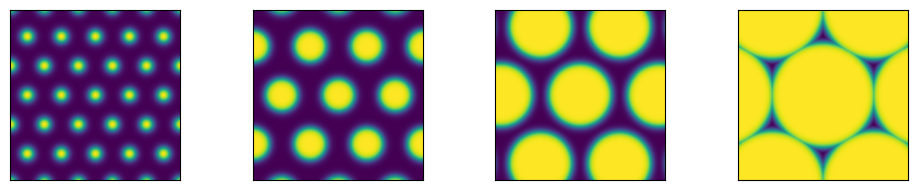

In [232]:
fig,axs = plt.subplots(1,4,figsize=(10,2))
step_centers = np.linspace(.3,.9,4)
step_sharpness = np.linspace(10,30,4)
lattice_as = np.linspace(2,6,4)
for ii in range(4):
    z, ext = generate_distance_field_lattice(
    step_center=step_centers[ii], step_sharpness=step_sharpness[ii], lattice_a=lattice_as[ii])
    axs[ii].imshow(z)
    plt.sca(axs[ii])
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.savefig('C06_2dschematic_generator_fig4.svg', format='svg', bbox_inches='tight')


# 1d plot

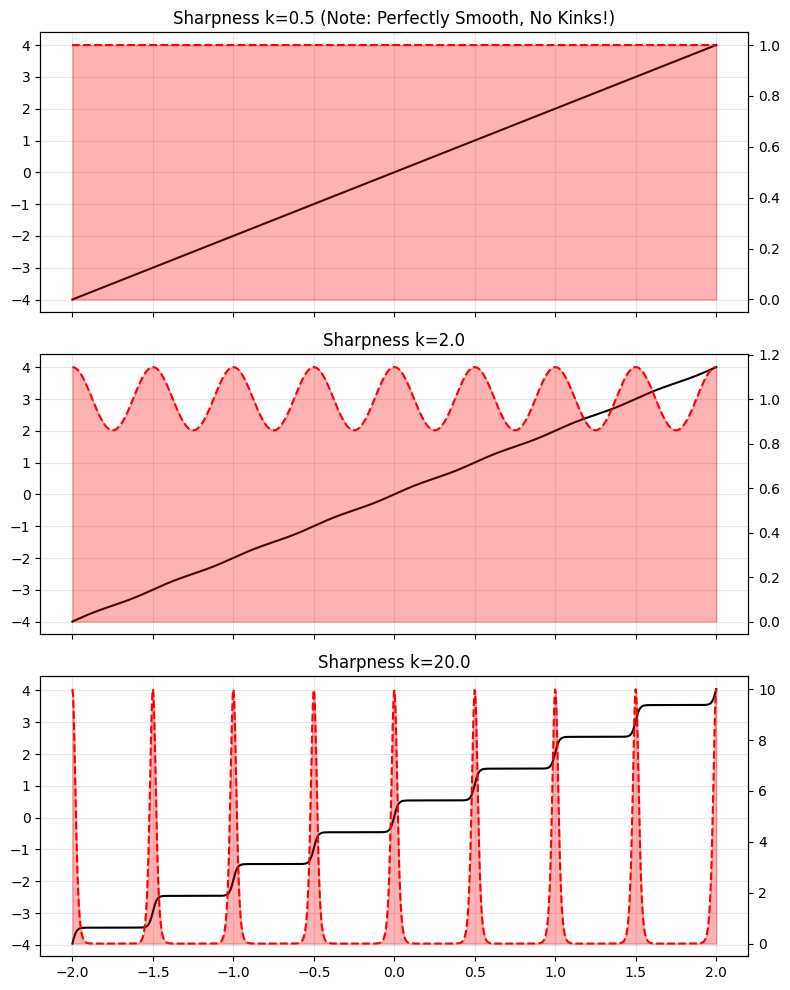

In [151]:
import numpy as np
import matplotlib.pyplot as plt

def generate_smooth_staircase_pulse(
    x: np.ndarray, 
    density: float = 5.0, 
    sharpness: float = 2.0
) -> tuple[np.ndarray, np.ndarray]:
    """
    Generates a perfectly smooth (C-infinity) Staircase and Pulse Train.
    
    Instead of finding the nearest integer (which causes kinks), 
    this calculates the superposition of all relevant smooth steps.
    
    S(u) = Sum_n [ 0.5 * (1 + tanh(k * (u - n))) ] - Offset
    """
    
    # 1. Phase Coordinate
    u = x * density
    
    # 2. Determine summation range (Integer indices)
    # We need to sum over integers 'n' that are close enough to the current 'u'.
    # Tanh decays to +/- 1.0 when |k*delta| > 5 roughly.
    # So we need margin > 5 / sharpness.
    margin = int(np.ceil(10.0 / (sharpness + 1e-5))) + 2
    
    n_min = int(np.floor(u.min())) - margin
    n_max = int(np.ceil(u.max())) + margin
    
    # Create a grid of integer indices [1, N_integers]
    n_indices = np.arange(n_min, n_max + 1)
    
    # 3. Vectorized Superposition (Broadcasting)
    # Shape of u: (M, 1)
    # Shape of n: (1, N)
    # Shape of delta: (M, N)
    u_col = u[:, np.newaxis]
    n_row = n_indices[np.newaxis, :]
    
    delta = u_col - n_row # Distance to every integer
    
    # --- Staircase Calculation ---
    # Each integer n contributes a step of height 1.
    # Step function: 0.5 * (1 + tanh(k * (u-n)))
    # Range of this function is 0 to 1.
    step_contributions = 0.5 * (1 + np.tanh(sharpness * delta))
    
    # Sum all contributions
    staircase_raw = np.sum(step_contributions, axis=1)
    
    # Centering Correction: 
    # We want S(0) to be 0 (or close to the center relative to x)
    # At u=0, the sum creates an offset based on how many negative integers we included.
    # We simply subtract the value at u=0 (or extrapolate) to zero the origin.
    # For robust centering relative to the domain origin:
    zero_idx = np.abs(u).argmin()
    staircase = staircase_raw - staircase_raw[zero_idx]
    
    # --- Pulse Train Calculation ---
    # Derivative of sum is sum of derivatives.
    # P(u) = Sum_n [ (k/2) * sech^2(k * (u-n)) ]
    
    # Clip for numerical stability of cosh
    cosh_arg = np.clip(sharpness * delta, -50, 50)
    
    # Amplitude = Sharpness / 2 (Area Conservation Rule)
    pulse_contributions = (sharpness / 2.0) * (1.0 / np.cosh(cosh_arg)**2)
    
    pulse = np.sum(pulse_contributions, axis=1)
    
    return staircase, pulse

# --- Verification Logic ---
if __name__ == "__main__":
    x_domain = np.linspace(-2, 2, 1000)
    rho = 2.0
    
    # Test very low sharpness to check for smoothness (No Kinks!)
    # k=0.5 means the steps are wider than the lattice spacing -> Strong overlap
    params = [0.5, 2.0, 20.0]
    
    fig, axes = plt.subplots(3, 1, figsize=(8, 10), sharex=True)
    
    for i, k in enumerate(params):
        S, P = generate_smooth_staircase_pulse(x_domain, density=rho, sharpness=k)
        
        ax = axes[i]
        ax.plot(x_domain, S, 'k-', label='Staircase')
        
        ax2 = ax.twinx()
        ax2.fill_between(x_domain, P, color='red', alpha=0.3)
        ax2.plot(x_domain, P, 'r--', label='Pulse')
        
        ax.set_title(f"Sharpness k={k}")
        ax.grid(True, alpha=0.3)
        
        # Highlight: Even at k=0.5, the curve is perfectly smooth sinusoidal-like
        if k < 1.0:
            ax.set_title(f"Sharpness k={k} (Note: Perfectly Smooth, No Kinks!)")

    plt.tight_layout()
    plt.show()

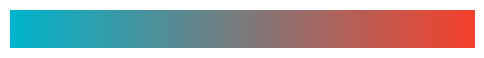

In [176]:
import matplotlib.pyplot as plt

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

first_color = colors[0]  # '#1f77b4' (tab:blue)
second_color = colors[1] # '#ff7f0e' (tab:orange)
first_color = '#E66100'
second_color ='#009E73'# colors[1] # '#ff7f0e' (tab:orange)
first_color = '#6B9AC4'
second_color ='#FF6F61'# colors[1] # '#ff7f0e' (tab:orange)
first_color = '#00B5CC'
second_color = '#F6412D'

from matplotlib.colors import LinearSegmentedColormap

cmap = LinearSegmentedColormap.from_list('first_to_second', [first_color, second_color])
import numpy as np

plt.figure(figsize=(6, 0.5))
plt.imshow([np.linspace(0, 1, 256)], aspect='auto', cmap=cmap)
plt.axis('off')
plt.show()


[0. 2.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]


<>:27: SyntaxWarning: invalid escape sequence '\p'
<>:27: SyntaxWarning: invalid escape sequence '\p'
C:\Users\user\AppData\Local\Temp\ipykernel_40812\79072574.py:27: SyntaxWarning: invalid escape sequence '\p'
  plt.ylabel("r$\phi$ [arb.]")


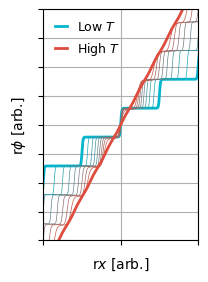

In [274]:

dw_density_start = 2
dw_density_end = 5
dw_smoothness_start = 40
dw_smoothness_end = 2

num_schematics = 10
dw_density = np.linspace(dw_density_start,dw_density_end,num_schematics)
dw_smoothness = np.linspace(dw_smoothness_start,dw_smoothness_end,num_schematics)

fig,ax = plt.subplots(1,1,figsize=(2,3))
# for iax in range(2):
#     plt.sca(ax[iax])
#     plt.axhline(y=0, color='k', lw=1,ls='--')
#     plt.axvline(x=0, color='k', lw=1,ls='--')
# plt.ylim(-2,2)
plt.grid(True)
ax  = plt.gca()
for i in range(num_schematics):
    # x,phi,dlt,sth = arr_phis(dw_density[i],dw_smoothness[i],0)
    x,phi,dlt,sth = arr_phis(dw_density[i],dw_smoothness[i],0)
    phi = (phi - phi[::-1]) / 2
    lw = 2 if i == 0 or i == num_schematics - 1 else .5
    label = 'Low $T$' if i == 0 else 'High $T$' if i == num_schematics - 1 else None
    phi,dlt = generate_smooth_staircase_pulse(x_domain, density=dw_density[i], sharpness=dw_smoothness[i])
    plt.plot(x_domain, phi, c=cmap(i/num_schematics), lw=lw, label=label)
    
plt.ylabel("r$\phi$ [arb.]")
plt.xlabel("r$x$ [arb.]")
    

ax.legend(fontsize=9, frameon=False, loc='upper left', handlelength=1)
plt.xlim(-1,1)
plt.ylim([-4,4])

# ax.set_xticks([])
# ax.set_yticks([])
ax.set_xticklabels([]) 
ax.set_yticklabels([])
plt.grid(True)
plt.grid(True)
